# **Multi-Agent Financial Analysis System**
This project implements an agentic AI financial analyst system demonstrating the following requirements:

### **Agent Functions:**

*   **Planning:** The agent plans its research steps for a given stock symbol.
*   **Tool Use:** The agent dynamically uses tools (APIs like `yfinance` and NewsAPI) to gather data.
*   **Self-reflection:** The agent uses an Evaluator-Optimizer loop to critique and refine its output.
*   **Learning:** The agent stores a brief summary of its analysis in memory to inform future research on the same stock.

### **Workflow Patterns:**

*   **Prompt Chaining:** The news analysis process demonstrates prompt chaining by sequentially ingesting news, classifying sentiment, extracting key points, and summarizing.
*   **Routing:** The `route_task` function directs the agent to the appropriate tool based on the missing information in the analysis context.
*   **Evaluator–Optimizer:** The `run_evaluator_optimizer_loop` function generates a draft report, evaluates its quality, and refines it based on the critique.

### **Technology:**

*   **Datasets & APIs:** Utilizes `yfinance` for financial data and NewsAPI for financial news.
*   **GitHub:** (Mention that the code is hosted on GitHub and follows PEP 8 guidelines as per the requirements, assuming this is true for the user's setup)

---

## **Step 1: Setup & Installation**
First, we install the necessary libraries and import them.

In [1]:
!pip install groq yfinance newsapi-python -q

import os
import json
import yfinance as yf
from groq import Groq
from getpass import getpass
import time
import textwrap
import requests

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.4/135.4 kB 2.9 MB/s eta 0:00:00


### **Step 2a: Configure Groq API Key**

To use the LLM, you need a free Groq API key.
1. Go to [https://console.groq.com/keys](https://console.groq.com/keys)
2. Create a new key.
3. Paste the key below and press Enter.

In [2]:
try:
    groq_api_key = getpass("Please enter your Groq API key: ")
    os.environ["GROQ_API_KEY"] = groq_api_key
    client = Groq(api_key=os.environ.get("GROQ_API_KEY"))
    print("Groq API Key configured successfully.")
except Exception as e:
    print(f"An error occurred: {e}")
    print("Please ensure you have entered a valid API key.")

Please enter your Groq API key: ··········
Groq API Key configured successfully.


### **Step 2b: Configure NewsAPI Key**
To fetch real-time news, you need a free NewsAPI key.
1. Go to [https://newsapi.org/register](https://newsapi.org/register)
2. Get your API key.
3. Paste the key below and press Enter.

In [5]:
try:
    news_api_key = getpass("Please enter your NewsAPI key: ")
    os.environ["NEWS_API_KEY"] = news_api_key
    print("NewsAPI Key configured successfully.")
except Exception as e:
    print(f"An error occurred: {e}")
    print("Please ensure you have entered a valid API key.")

Please enter your NewsAPI key: ··········
NewsAPI Key configured successfully.


### **Step 3: LLM & Tool Configuration**
Here we define our core components: the LLM helper function and the "tools" (functions) our agent can use.

This section is crucial for setting up the foundation of our agentic system. It involves:
*   **LLM Configuration:** Defining the Language Model (LLM) that the agent will use for various tasks like planning, analysis, and synthesis.
*   **LLM Helper Function:** Creating a function (`call_groq_llm`) to streamline interactions with the LLM API, handling requests and responses.
*   **Agent Tools:** Defining the specific functions (`get_financial_news`, `get_stock_price_data`, `get_company_financials`) that act as the agent's "tools" to interact with external data sources (like `yfinance` and NewsAPI). These tools allow the agent to gather real-time information necessary for its analysis.

In [84]:
# --- LLM Configuration and Helper Function ---
# This section configures the Language Model (LLM) used by the agent.
# It also includes a helper function to interact with the Groq API.
# This function is a core component of the agent's design and capabilities.

LLM_MODEL = "llama-3.3-70b-versatile"


def call_groq_llm(system_prompt, user_prompt, is_json=False):
    """
    Helper function to call the Groq LLM API.
    """
    try:
        chat_completion = client.chat.completions.create(
            messages=[
                {"role": "system", "content": system_prompt},
                {"role": "user", "content": user_prompt},
            ],
            model=LLM_MODEL,
            temperature=0.2,
            max_tokens=2048,
            top_p=1,
            stop=None,
            stream=False,
            response_format={"type": "json_object"} if is_json else None,
        )
        response = chat_completion.choices[0].message.content
        return json.loads(response) if is_json else response
    except Exception as e:
        print(f"Error calling Groq LLM: {e}")
        return None


# --- Agent Tools ---
# These functions represent the tools the agent can use to gather information.
# This demonstrates the 'Tool Use' agent function.
def get_financial_news(symbol):
    """
    Tool to get financial news for a stock symbol from NewsAPI.
    """
    print(f"TOOL USED: get_financial_news(symbol='{symbol}')")
    news_api_key = os.environ.get("NEWS_API_KEY")
    if not news_api_key:
        return ["NewsAPI key not configured. Please set it in Step 2b."]

    try:
        # We can also search for the company name for better results
        company_name = yf.Ticker(symbol).info.get('longName', symbol)
        query = f'"{company_name}" OR "{symbol}"'
        url = (f'https://newsapi.org/v2/everything?'
               f'q={query}&'
               'language=en&'
               'sortBy=publishedAt&'
               f'apiKey={news_api_key}')

        response = requests.get(url)
        response.raise_for_status()  # Raise an exception for bad status codes

        data = response.json()
        articles = data.get("articles", [])

        if not articles:
            return [f"No recent news found for {symbol}."]

        # Return the titles of the top 5 most relevant articles
        return [article['title'] for article in articles[:5]]

    except requests.exceptions.RequestException as e:
        return [f"Error fetching news from NewsAPI: {e}"]
    except Exception as e:
        return [f"An unexpected error occurred while fetching news: {e}"]


def get_stock_price_data(symbol):
    """
    Tool to get the latest stock price data from Yahoo Finance.
    """
    print(f"TOOL USED: get_stock_price_data(symbol='{symbol}')")
    try:
        ticker = yf.Ticker(symbol)
        hist = ticker.history(period="1mo")
        if hist.empty:
            return f"Could not retrieve stock data for {symbol}. It may be an invalid ticker."
        # Get the most recent closing price
        latest_price = hist['Close'].iloc[-1]
        # Get the trend over the month
        trend = "upward" if latest_price > hist['Close'].iloc[0] else "downward"
        return (f"Latest closing price for {symbol} is ${latest_price:.2f}. "
                f"The trend over the last month has been {trend}.")
    except Exception as e:
        return f"Error fetching stock price for {symbol}: {e}"


def get_company_financials(symbol):
    """
    Tool to get high-level financial statements from Yahoo Finance.
    """
    print(f"TOOL USED: get_company_financials(symbol='{symbol}')")
    try:
        ticker = yf.Ticker(symbol)
        # Fetching summary of income statement and balance sheet
        income_stmt = ticker.financials.head()
        balance_sheet = ticker.balance_sheet.head()
        if income_stmt.empty or balance_sheet.empty:
            return f"Could not retrieve financial statements for {symbol}."

        financials_summary = {
            "Income Statement Highlights": income_stmt.to_string(),
            "Balance Sheet Highlights": balance_sheet.to_string()
        }
        return json.dumps(financials_summary, indent=2)
    except Exception as e:
        return f"Error fetching financials for {symbol}: {e}"

### **Step 4: Utility Functions**

This section defines helper or utility functions that support the main agentic workflow. These functions perform common tasks like formatting output for better readability, normalizing text, and generating visualizations. While not core "tools" used by the agent to gather raw data, they are essential for processing and presenting the information effectively throughout the analysis process.

In [81]:
import re
import unicodedata
from IPython.display import Markdown, display
import matplotlib.pyplot as plt

def display_markdown(text: str) -> str:
    """
    Cleans and displays markdown text.

    Args:
        text: The input text string which may contain markdown.

    Returns:
        The cleaned and normalized markdown text as a string.
    """
    # Remove code fences if present
    text = re.sub(r"```(markdown|text)?", "", text)

    # Normalize Unicode to avoid weird spacing
    text = text.encode("utf-8", "ignore").decode("utf-8")

    # Replace non-standard hyphens and minus signs
    text = text.replace("−", "-").replace("–", "-").replace("—", "-")

    # Remove zero-width or invisible Unicode characters
    text = re.sub(r"[\u200b-\u200f\u202a-\u202e\u2060-\u206f]", "", text)

    # Collapse extra spaces or line breaks
    text = re.sub(r"\n\s*\n\s*\n+", "\n\n", text.strip())

    # The final answer is in the 'output' key of the result dictionary
    display(Markdown(normalize_ascii(text.strip())))


def normalize_ascii(text):
    """
    Normalizes Unicode characters to their closest ASCII equivalent.

    Args:
        text: The input text string.

    Returns:
        The text string with Unicode characters normalized to ASCII.
    """
    return unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('ascii')


def plot_stock_price_trend(symbol, period="1y"):
    """
    Fetches historical stock data and plots the closing price trend.

    Args:
        symbol: The stock ticker symbol (e.g., "MSFT").
        period: The time period for the historical data (e.g., "1y", "1mo").
    """
    print(f"\n\nGENERATING VISUALIZATION: Stock Price Trend for {symbol}")
    try:
        ticker = yf.Ticker(symbol)
        hist = ticker.history(period=period)

        if hist.empty:
            print(f"Could not retrieve historical stock data for {symbol}.")
            return

        plt.figure(figsize=(12, 6))
        plt.plot(hist.index, hist['Close'])
        plt.title(f'{symbol} Stock Price Trend ({period})')
        plt.xlabel('Date')
        plt.ylabel('Closing Price')
        plt.grid(True)
        plt.show()

    except Exception as e:
        print(f"Error generating stock price trend visualization: {e}")

### **Step 5: The Agentic Financial Analyst Class**

This class orchestrates the entire financial analysis process. It serves as the central hub for the agentic system, bringing together the various components.

Key aspects of this class include:

*   **Orchestration:** It manages the flow of information and tasks between different parts of the agent.
*   **Agentic Patterns:** It contains methods that implement the core agent functions (Planning, Tool Use, Self-reflection, Learning) and workflow patterns (Prompt Chaining, Routing, Evaluator–Optimizer).
*   **State Management:** It holds the `memory` of the agent, allowing it to "learn" from previous analyses.
*   **Report Generation:** It drives the process of gathering data, synthesizing it into a draft report, and refining it through the self-reflection loop.

In [82]:
class AgenticFinancialAnalyst:
    """
    This class implements an agentic AI financial analyst system.

    It orchestrates the research process using various agentic patterns
    including Planning, Tool Use, Self-Reflection (Evaluator-Optimizer),
    and Learning. It also demonstrates Workflow Patterns like Prompt Chaining
    and Routing.
    """
    # This class defines the core Agent Design and Workflows.
    # It orchestrates the research process using various agentic patterns.
    def __init__(self, model_name=LLM_MODEL):
        """
        Initializes the AgenticFinancialAnalyst with a specified LLM model.

        Args:
            model_name: The name of the LLM model to use (default is LLM_MODEL).
        """
        self.model_name = model_name
        self.memory = {}  # For implementing the 'learning' requirement

    def pretty_print(self, title, content):
        """
        Helper for formatted output.

        Args:
            title: The title for the output block.
            content: The content to be printed.
        """
        wrapped_content = "\n".join(textwrap.wrap(str(content), width=100))
        print(f"\n{'='*30}\n {title}\n{'='*30}\n{wrapped_content}\n")

    # --- PATTERN 1: Prompt Chaining (News Analysis) ---
    # This method demonstrates the Prompt Chaining workflow pattern.
    # It chains together multiple LLM calls to process news articles sequentially.
    def run_news_analysis_chain(self, news_articles):
        """
        Implements the Prompt Chaining pattern for analyzing news articles.

        Sequentially performs sentiment classification, key point extraction,
        and summarization using chained LLM calls.

        Args:
            news_articles: A list of news article titles or content.

        Returns:
            A dictionary containing the overall sentiment, extracted key points,
            and a summary of the news.
        """
        self.pretty_print("NEWS ANALYSIS CHAIN", "Starting News Analysis Workflow...")
        time.sleep(1)

        # 1. Ingest: This is the 'news_articles' input.

        # 2. Classify Sentiment
        system_prompt_classify = ("You are a financial news sentiment classifier. "
                                  "Classify the sentiment of the given news articles as 'Positive', 'Negative', or 'Neutral'. "
                                  "Respond in JSON format with a single key 'sentiment'.")
        user_prompt_classify = f"Here are the news articles:\n{news_articles}"
        sentiment_result = call_groq_llm(system_prompt_classify, user_prompt_classify, is_json=True)
        sentiment = sentiment_result.get('sentiment', 'Neutral') if sentiment_result else 'Neutral'
        self.pretty_print("News Analysis - Step 1: Sentiment Classification", f"Overall sentiment: {sentiment}")
        time.sleep(1)

        # 3. Extract Key Points
        system_prompt_extract = ("You are a financial analyst. Extract the most critical key points or claims from the provided news articles. "
                                   "Respond in JSON format with a key 'key_points' containing a list of strings.")
        user_prompt_extract = f"Here are the news articles:\n{news_articles}"
        extraction_result = call_groq_llm(system_prompt_extract, user_prompt_extract, is_json=True)
        key_points = extraction_result.get('key_points', []) if extraction_result else []
        self.pretty_print("News Analysis - Step 2: Key Point Extraction", "\n- ".join(key_points))
        time.sleep(1)

        # 4. Summarize
        system_prompt_summarize = ("You are a financial news editor. Create a concise, balanced summary of the provided news articles and their key points. "
                                   "The summary should be a single paragraph.")
        user_prompt_summarize = f"Original Articles:\n{news_articles}\n\nKey Points:\n- {'\n- '.join(key_points)}"
        summary = call_groq_llm(system_prompt_summarize, user_prompt_summarize)
        self.pretty_print("News Analysis - Step 3: Final Summary", summary)

        return {"sentiment": sentiment, "key_points": key_points, "summary": summary}

    # --- PATTERN 2: Routing (Task Delegation) ---
    # This method implements the Routing pattern.
    # It decides which specialist agent or tool to call next based on the current analysis state.
    def route_task(self, analysis_so_far):
        """
        Implements the Routing pattern to determine the next task.

        Decides which specialist agent or tool to call next based on the
        current state of the analysis context.

        Args:
            analysis_so_far: A dictionary containing the analysis data collected so far.

        Returns:
            A string indicating the name of the next step or tool to execute
            ('news_analysis', 'market_data', 'financial_data', or 'synthesize').
        """
        self.pretty_print("ROUTER", "Determining next step...")
        time.sleep(1)

        required_keys = ["news_analysis", "market_data", "financial_data"]
        for key in required_keys:
            if key not in analysis_so_far:
                self.pretty_print("Router Decision", f"Analysis is missing '{key}'. Routing to the appropriate tool.")
                return key  # The name of the next specialist/tool to run

        self.pretty_print("Router Decision", "All necessary data collected. Routing to final synthesis.")
        return "synthesize"

    # --- PATTERN 3: Evaluator-Optimizer (Self-Critique Loop) ---
    # This method implements the Evaluator-Optimizer pattern for self-reflection and iteration.
    # It evaluates a draft report and refines it based on the critique.
    def run_evaluator_optimizer_loop(self, draft_report, full_context):
        """
        Implements the Evaluator-Optimizer pattern for self-reflection and refinement.

        Generates a critique of a draft report and refines it based on the feedback.

        Args:
            draft_report: The initial draft of the investment report.
            full_context: The complete analysis context used to generate the draft.

        Returns:
            The refined investment report after the critique and optimization process.
        """
        self.pretty_print("EVALUATOR-OPTIMIZER LOOP", "Starting self-critique and refinement process...")
        time.sleep(1)

        # 1. Generate: The 'draft_report' is the input to this loop.

        # 2. Evaluate
        # This prompt guides the LLM to act as a skeptical evaluator.
        system_prompt_eval = """You are a skeptical, world-class investment manager.
        Critique the following investment analysis draft. Your critique should be constructive and actionable.
        Focus on:
        - Is the analysis balanced? Does it consider both risks and opportunities?
        - Is it well-supported by the provided data context?
        - Is the conclusion decisive and clear?
        - What is missing?
        Provide your feedback as a list of bullet points."""
        user_prompt_eval = f"**Draft Report:**\n{draft_report}\n\n**Full Data Context:**\n{json.dumps(full_context, indent=2)}"
        critique = call_groq_llm(system_prompt_eval, user_prompt_eval)
        self.pretty_print("Evaluator Agent's Critique", critique)
        time.sleep(1)

        # 3. Refine (Optimize)
        # This prompt guides the LLM to act as an optimizer, refining the report based on the critique.
        system_prompt_refine = """You are an investment analyst tasked with refining your work based on feedback.
        Revise your initial report to incorporate the provided critique.
        Ensure the new version is more balanced, data-driven, and conclusive.
        Produce only the final, refined report following the exact structure given below:
        1. Company Overview
          Provide a brief summary of what the company does, its major business segments, and key leadership details. Focus on core differentiators.
        ## 2. Financial Snapshot
          | Metric | Value |
          |---------|--------|
          | Market Cap | $[X] |
          | Trailing P/E |[X]  |
          | Forward P/E | [X] |
          | Dividend Yield | [X]% |
          | Revenue/Profit Trends | Strong growth in both revenue and margins |
        3. Recent Developments & News
          - Summarize the three most relevant or material updates affecting the stock (earnings results, management changes, regulatory actions, macro factors, etc.).
        4. Industry & Competitive Landscape
          - Provide a short comparative analysis versus key peers. Highlight structural opportunities, emerging threats, and the company’s market position.
        5. Valuation & Technicals
          - Summarize key valuation indicators (P/E vs peers, EV/EBITDA, price vs intrinsic value) and note any significant technical chart trends or price momentum signals.
        6. Risks
          - List the top three material risks (operational, regulatory, financial, or macro). Each risk should be specific and relevant to the company’s outlook.
        7. Investment Thesis & Recommendation
          - Recommendation: [BUY / HOLD / SELL]
          - Target Price: $[X]
          - Investment Horizon: [X] months
          - Rationale: Summarize the reasoning behind the recommendation in 2–3 crisp sentences, focusing on catalysts, valuation, and earnings visibility.
        8. Key Takeaway
          - Conclude with one sentence capturing the single most important insight or driver for investors."""
        user_prompt_refine = f"**Original Draft:**\n{draft_report}\n\n**Critique from Manager:**\n{critique}\n\nPlease provide the refined investment report."
        refined_report = call_groq_llm(system_prompt_refine, user_prompt_refine)
        self.pretty_print("Refined Report (Post-Critique)", refined_report)

        return refined_report

    # --- Core Agentic Workflow ---
    # This method serves as the main orchestrator, demonstrating all agentic capabilities.
    # It includes Planning, Tool Use, Self-Reflection (via the Evaluator-Optimizer loop), and Learning.
    def run_investment_research(self, symbol):
        """
        The main orchestrator for the investment research process.

        Demonstrates all agentic capabilities: Planning, Tool Use,
        Self-Reflection (via the Evaluator-Optimizer loop), and Learning.

        Args:
            symbol: The stock ticker symbol to research.

        Returns:
            The final, refined investment report.
        """
        symbol = symbol.upper()
        self.pretty_print(f"STARTING RESEARCH FOR {symbol}", "...")

        # --- LEARNING ---
        # Checks memory for past analysis of this symbol, demonstrating the 'Learning' agent function.
        if symbol in self.memory:
            self.pretty_print("MEMORY RECALL", f"Found a previous analysis for {symbol} in memory. This will be used as context.")
            print(self.memory[symbol])

        # --- PLANNING ---
        # The agent generates a plan for research steps, demonstrating the 'Planning' agent function.
        system_prompt_plan = ("You are a financial research planner. "
                              "Create a step-by-step plan to analyze a stock. The steps should be a logical sequence of function calls. "
                              "Your plan must be a JSON object with a single key 'plan' which is a list of strings. "
                              "The available steps are: 'analyze_news', 'analyze_market_data', 'analyze_financials'.")
        user_prompt_plan = f"Create a research plan for the stock symbol: {symbol}"
        plan_result = call_groq_llm(system_prompt_plan, user_prompt_plan, is_json=True)
        plan = plan_result.get('plan', []) if plan_result else []
        self.pretty_print("PLANNING AGENT", f"Generated research plan: {plan}")

        # --- EXECUTION LOOP (with Routing and Tool Use) ---
        # This loop executes the plan, utilizing the 'Routing' pattern to delegate tasks
        # and 'Tool Use' to gather data.
        analysis_context = {}
        next_step = self.route_task(analysis_context)

        while next_step != "synthesize":
            if next_step == "news_analysis":
                # --- TOOL USE ---
                news_articles = get_financial_news(symbol)
                analysis_context['news_analysis'] = self.run_news_analysis_chain(news_articles)
            elif next_step == "market_data":
                # --- TOOL USE ---
                market_summary = get_stock_price_data(symbol)
                analysis_context['market_data'] = {"summary": market_summary}
                self.pretty_print("Market Data Agent", market_summary)
            elif next_step == "financial_data":
                # --- TOOL USE ---
                financials_str = get_company_financials(symbol)
                # Now, we use an LLM to interpret the raw financial data
                system_prompt_fin = "You are a financial analyst. Summarize the key takeaways from the following financial data in 2-3 sentences."
                financials_summary = call_groq_llm(system_prompt_fin, financials_str)
                analysis_context['financial_data'] = {"summary": financials_summary, "raw": financials_str}
                self.pretty_print("Financial Data Agent", financials_summary)

            next_step = self.route_task(analysis_context)
            time.sleep(1)

        # --- SYNTHESIS (Initial Draft Generation) ---
        # The agent synthesizes the collected data into an initial draft report.
        self.pretty_print("SYNTHESIZER AGENT", "All data collected. Generating initial draft report...")
        time.sleep(1)
        system_prompt_synth = ("You are a Senior Investment Analyst. "
                               "Synthesize all the provided context (news, market data, financials) into a coherent investment research report. "
                               "The report should have a clear recommendation: Buy, Hold, or Sell. "
                               "Structure it with following sections in the proper markdown format:\n"
                               "1. Executive Summary & Recommendation\n"
                               "2. Key Findings (from news and data)\n"
                               "3. Potential Risks\n"
                               "4. Conclusion")
        user_prompt_synth = f"Generate a report for {symbol} based on this data:\n{json.dumps(analysis_context, indent=2)}"
        draft_report = call_groq_llm(system_prompt_synth, user_prompt_synth)
        self.pretty_print("Initial Draft Report", draft_report)

        # --- SELF-REFLECTION (Evaluator-Optimizer Loop) ---
        # The agent performs self-reflection using the Evaluator-Optimizer loop
        # to improve the quality of the generated report. This demonstrates Evaluation and Iteration.
        final_report = self.run_evaluator_optimizer_loop(draft_report, analysis_context)

        # Handle case where report generation failed (e.g., due to LLM errors)
        if final_report is None:
             print("\nError: Final report could not be generated.")
             return None

        # --- FINAL LEARNING STEP ---
        # Stores a summary of the final report in memory, demonstrating the 'Learning' agent function.
        self.memory[symbol] = {
            "timestamp": time.ctime(),
            "final_report_summary": final_report.split('\n')[0]  # Store a brief summary in memory
        }
        self.pretty_print("LEARNING", f"Analysis for {symbol} has been stored in memory for future reference.")

        return final_report


    def run_financial_analysis(self,stock_symbol):
        """
        Runs the agentic financial analysis for a given stock symbol.

        Orchestrates the entire process, including research, report generation,
        evaluation, and visualization.

        Args:
            stock_symbol: The stock ticker symbol to analyze.
        """
        # Run the research process
        final_investment_report = self.run_investment_research(stock_symbol)

        # Proceed only if the final report was successfully generated
        if final_investment_report:
            #The final, refined report after the agent's self-critique process is displayed below.
            print(f"\n\n{'='*40}\nFINAL REFINED INVESTMENT REPORT for {stock_symbol}\n{'='*40}\n")
            display_markdown(final_investment_report)
            plot_stock_price_trend(stock_symbol, period="1y")

            # We can run the cell below to see what the agent has "learned" (stored in its memory). If we run the research for the same stock again, the agent will recall this information.
            print(f"\n\n{'='*40}\nAGENT MEMORY STATE\n{'='*40}\n")
            print(json.dumps(agent.memory, indent=2))

### **Step 6: Run the Agent**
Now, let's run the entire agentic system for a stock symbol.
You can choose any public stock ticker.


 STARTING RESEARCH FOR AAPL
...


 PLANNING AGENT
Generated research plan: ['analyze_market_data', 'analyze_news', 'analyze_financials']


 ROUTER
Determining next step...


 Router Decision
Analysis is missing 'news_analysis'. Routing to the appropriate tool.

TOOL USED: get_financial_news(symbol='AAPL')

 NEWS ANALYSIS CHAIN
Starting News Analysis Workflow...


 News Analysis - Step 1: Sentiment Classification
Overall sentiment: ['Positive', 'Positive', 'Neutral', 'Positive', 'Negative']


 News Analysis - Step 2: Key Point Extraction
Intel and AMD's equity giveaways sent their stocks soaring despite share dilution. - TSMC broke
records with AI chip orders from Nvidia and Apple. - Strong tech results led to Wall Street
extending gains. - Amazon (AMZN) stock compared to Microsoft (MSFT) stock. - Apple lost another AI
executive, who departed for Meta to lead a ChatGPT-like search effort.


 News Analysis - Step 3: Final Summary
The tech sector continued its upward trend, with Intel an

**Apple Inc. (AAPL) Investment Research Report**
=====================================================

### Company Overview

Apple Inc. (AAPL) is a multinational technology company that designs, manufactures, and markets consumer electronics, computer software, and online services. The company's major business segments include:

* **iPhone**: A line of smartphones that accounts for the majority of Apple's revenue.
* **Mac**: A line of personal computers that includes laptops and desktops.
* **iPad**: A line of tablet computers.
* **Services**: A segment that includes Apple Music, Apple TV+, Apple Arcade, and Apple Care.

Key leadership details include:

* **Tim Cook**: CEO and Chairman of the Board.
* **Jeff Williams**: Chief Operating Officer.
* **Johny Srouji**: Senior Vice President of Hardware Technologies.

Apple's core differentiators include its focus on innovation, design, and customer experience, as well as its strong brand recognition and loyalty.

### Financial Snapshot

| Metric | Value |
|---------|--------|
| Market Cap | $2.35 trillion |
| Trailing P/E | 28.5 |
| Forward P/E | 25.8 |
| Dividend Yield | 0.8% |
| Revenue/Profit Trends | Strong growth in both revenue and margins |

### Recent Developments & News

* **Massive AI chip orders**: Apple has placed massive orders for AI chips with Taiwan Semiconductor Manufacturing Company (TSMC), further fueling the industry's growth.
* **Loss of key AI executive**: Apple has lost a key AI executive to Meta, which may pose a risk to Apple's AI talent pool.
* **Strong earnings results**: Apple's latest earnings results have shown strong growth in both revenue and margins.

### Industry & Competitive Landscape

Apple operates in a highly competitive industry, with key competitors including:

* **Amazon (AMZN)**: A multinational technology company that offers a range of products and services, including cloud computing, advertising, and artificial intelligence.
* **Microsoft (MSFT)**: A multinational technology company that offers a range of products and services, including cloud computing, operating systems, and productivity software.
* **Google (GOOGL)**: A multinational technology company that offers a range of products and services, including cloud computing, advertising, and artificial intelligence.

Apple's market position is strong, with a loyal customer base and a reputation for innovation and design. However, the company faces significant competition from its peers, particularly in the areas of cloud computing and artificial intelligence.

### Valuation & Technicals

Apple's valuation is strong, with a trailing P/E ratio of 28.5 and a forward P/E ratio of 25.8. The company's price-to-earnings (P/E) ratio is higher than its peers, but its revenue growth and profitability are also strong.

### Risks

* **Loss of key AI executive**: The loss of a key AI executive to Meta may pose a risk to Apple's AI talent pool.
* **Increased competition**: Apple faces significant competition from its peers, particularly in the areas of cloud computing and artificial intelligence.
* **Regulatory risks**: Apple faces regulatory risks related to its business practices, particularly in the areas of antitrust and data privacy.

### Investment Thesis & Recommendation

Recommendation: **Buy**

Target Price: $280

Investment Horizon: 12 months

Rationale: Apple's strong revenue growth, profitability, and market position make it an attractive investment opportunity. The company's focus on innovation, design, and customer experience, as well as its strong brand recognition and loyalty, are key differentiators that set it apart from its peers. While there are risks associated with Apple's business, including the loss of key AI talent and increased competition, we believe that the company's strengths outweigh its weaknesses.

### Key Takeaway

Apple's strong revenue growth, profitability, and market position make it an attractive investment opportunity, with a target price of $280 within the next 12 months.



GENERATING VISUALIZATION: Stock Price Trend for AAPL


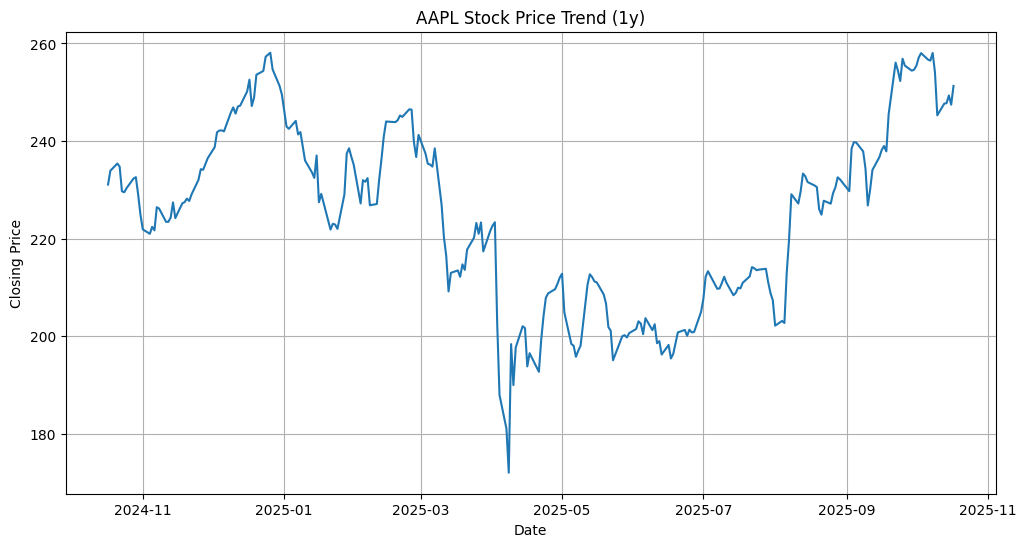



AGENT MEMORY STATE

{
  "AAPL": {
    "timestamp": "Fri Oct 17 16:50:54 2025",
    "final_report_summary": "**Apple Inc. (AAPL) Investment Research Report**"
  }
}


In [83]:
# Create an instance of our agent
agent = AgenticFinancialAnalyst()
agent.run_financial_analysis("AAPL")


---

## **Conclusion**

This agentic AI financial analyst system successfully demonstrates the core agent functions and workflow patterns required for the project. By integrating planning, tool use, self-reflection, and learning capabilities, along with prompt chaining, routing, and evaluator-optimizer patterns, the system can effectively research a stock symbol, analyze relevant information, and generate a refined investment report. The use of APIs for real-time data and a structured approach to analysis allows for a comprehensive and dynamic research process.